# Conflations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import sim_powerlaw, sim_combined
from neurodsp.utils import set_random_seed
from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.spectral.utils import rotate_timeseries
from neurodsp.plts import plot_time_series
from neurodsp.filt import filter_signal

from fooof import Bands
from fooof.utils import trim_spectrum
from fooof.sim.gen import gen_power_spectrum
from fooof.plts.spectra import plot_spectrum_shading, plot_spectra_shading

from utils import save_fig
from settings import BANDS, BAND_COLORS

In [2]:
import seaborn as sns
sns.set_context('poster')

In [3]:
set_random_seed(505)

## Settings

In [4]:
fs = 1000
n_seconds = 60

In [5]:
f_range = [2, 30]

In [6]:
times = create_times(n_seconds, fs)

In [7]:
# Notebook settings
SAVE = False

## Simulate Data

In [8]:
# Simulate some example coloured noise signals
white = sim_powerlaw(n_seconds, fs, 0)
pink = sim_powerlaw(n_seconds, fs, -1)

## Filtered Traces

In [9]:
# Set which data to plot
plot_data = pink

In [10]:
# Plot settings
filt_xlim = [5, 7]
filt_ylim = [-0.75, 0.75]
plt_kwargs = {'xlabel' : '', 'ylabel' : '', 'lw' : 3}

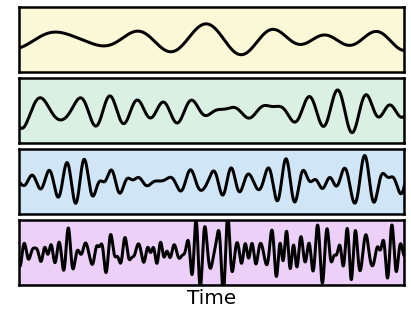

In [11]:
# Create a plot of the data filtered into different frequency ranges
_, axes = plt.subplots(len(BANDS), 1, figsize=(7, 5))
for ax, color, (label, filt_range) in zip(axes, list(BAND_COLORS.values()), BANDS):

    band_sig = filter_signal(plot_data, fs, 'bandpass', filt_range)
    plot_time_series(times, band_sig, ax=ax,
                     xlim=filt_xlim, ylim=filt_ylim, **plt_kwargs)
    ax.axvspan(filt_xlim[0], filt_xlim[1], alpha=0.2, color=color)
    ax.set_xticks([]); ax.set_yticks([]); 

plt.xlabel('Time', fontsize=20)
plt.subplots_adjust(hspace=0.1)
#save_fig(True, 'pink_noise_filters.pdf')

## Power Spectra

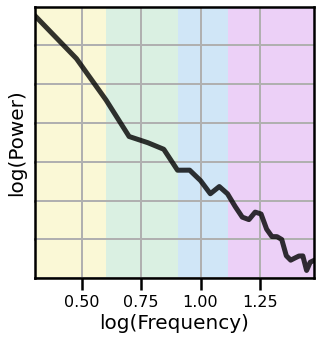

In [12]:
# Plot the power spectrum of the simulated signal
_, ax = plt.subplots(figsize=(5, 5))
freqs, powers = trim_spectrum(*compute_spectrum(pink, fs, nperseg=fs), f_range)
plot_spectrum_shading(freqs, powers, log_freqs=True,log_powers=True, alpha=0.8,
                      lw=5, color='black', shades=BANDS.definitions,
                      shade_colors=list(BAND_COLORS.values()), ax=ax)
plt.xlim(np.log10(f_range))
plt.gca().yaxis.set_tick_params(length=1)
plt.gca().set_yticklabels([]);
plt.ylim([-2.6, -1.2])
save_fig(True, 'pink_noise_psd_shaded.pdf')

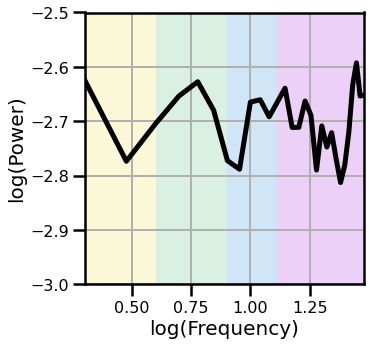

In [13]:
# Plot the power spectrum of the simulated signal
_, ax = plt.subplots(figsize=(5, 5))
freqs, powers = trim_spectrum(*compute_spectrum(white, fs, nperseg=fs), f_range)
plot_spectrum_shading(freqs, powers, log_freqs=True, log_powers=True,
                      lw=5, color='black', shades=BANDS.definitions,
                      shade_colors=list(BAND_COLORS.values()), ax=ax)
#plt.xlim(f_range)
plt.xlim(np.log10(f_range))
plt.ylim([-3, -2.5])
save_fig(SAVE, 'white_noise_psd.pdf')

## Spectral Rotation Effects

In [14]:
# Define the components of the combined signal
comps = {'sim_powerlaw' : {'exponent' : -1, 'f_range' : (0.5, 250)},
         'sim_oscillation' : {'freq' : 10}}

# Define relative power of the signal components
comp_vars = [1, 0.4]

In [15]:
# Simulate a combined signal
sig = sim_combined(n_seconds, fs, comps, comp_vars)

In [16]:
# Define settings for rotating the signal
exp_rot = -0.25
f_rotation = 10

In [17]:
# Rotate signal
sig_rot = rotate_timeseries(sig, fs, exp_rot, f_rotation)

In [19]:
# Compute power spectra 
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig, fs, nperseg=1*fs, noverlap=0.5*fs), [1, 150])
freqs2, powers2 = trim_spectrum(*compute_spectrum(sig_rot, fs, nperseg=1*fs, noverlap=0.5*fs), [1, 150])

In [20]:
# ...
BANDS.add_band('gamma', [30, 150])
BAND_COLORS['gamma'] = '#e60026'

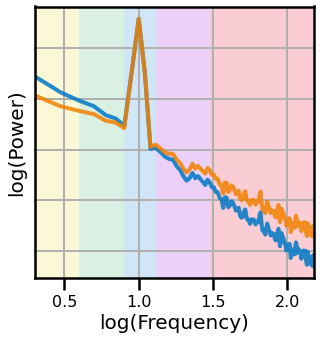

In [21]:
# Plot power spectra
_, ax = plt.subplots(figsize=(5, 5))
plot_spectra_shading(freqs1, [powers1, powers2], 
                     #[8, 12], shade_colors=BAND_COLORS['alpha'],
                     BANDS.definitions, shade_colors=list(BAND_COLORS.values()),
                     log_freqs=True, log_powers=True, lw=4, alpha=0.85, ax=ax)
plt.xlim(np.log10([2, 150]))
colors = ['#0077c7', '#f28100']
for line, color in zip(plt.gca().get_lines(), colors):
    line.set_color(color)
    
plt.gca().yaxis.set_tick_params(length=1)
plt.gca().set_yticklabels([]);
save_fig(True, 'spectral_rotation_psd.pdf')

In [22]:
# Compute the measured differences in band power between spectra
deltas = {}
for label, band in BANDS:
    deltas[label] = np.sum(trim_spectrum(freqs2, powers2, band)[1]) - \
        np.sum(trim_spectrum(freqs1, powers1, band)[1])

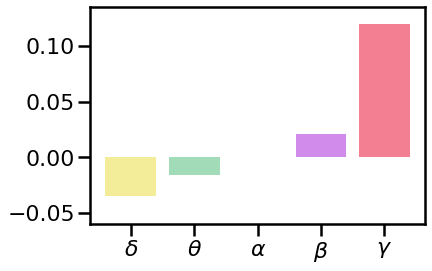

In [23]:
labels = [r'$\delta$', r'$\theta$', r'$\alpha$', r'$\beta$', r'$\gamma$']
plt.bar(list(range(len(deltas.values()))), deltas.values(),
        tick_label=labels, color=BAND_COLORS.values(), alpha=0.5)
plt.ylim([-0.06, 0.135])
save_fig(True, 'band_differences.pdf')

## Spectral Parameters

Note: this is adapted from [this page](https://fooof-tools.github.io/fooof/auto_motivations/measurements/plot_PeriodicAperiodicFeatures.html).

In [24]:
# Simulation Settings
nlv = 0
f_res = 0.1
f_range = [3, 35]

# Define baseline parameter values
ap_base = [0, 1.5]
pe_base = [[10, 0.5, 1], [22, 0.2, 2]]

# Define parameters sets with changes in each parameter
pw_diff = [[10, 0.311, 1], [22, 0.2, 2]]
cf_diff = [[11.75, 0.5, 1], [22, 0.2, 2]]
off_diff = [-0.126, 1.5]
exp_diff = [-0.87, 0.75]

In [25]:
# Create baseline power spectrum, to compare to
freqs, powers_base = gen_power_spectrum(f_range, ap_base, pe_base, nlv, f_res)

In [26]:
# Create comparison power spectra, with differences in different parameters of the data
_, powers_pw = gen_power_spectrum(f_range, ap_base, pw_diff, nlv, f_res)
_, powers_cf = gen_power_spectrum(f_range, ap_base, cf_diff, nlv, f_res)
_, powers_off = gen_power_spectrum(f_range, off_diff, pe_base, nlv, f_res)
_, powers_exp = gen_power_spectrum(f_range, exp_diff, pe_base, nlv, f_res)

In [27]:
# Collect the comparison power spectra together
all_powers = {
    'Alpha Power Change' : powers_pw,
    'Alpha Frequency Change' : powers_cf,
    'Offset Change' : powers_off,
    'Exponent Change' : powers_exp
}

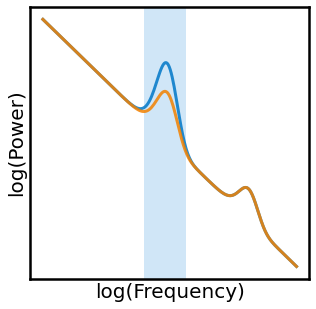

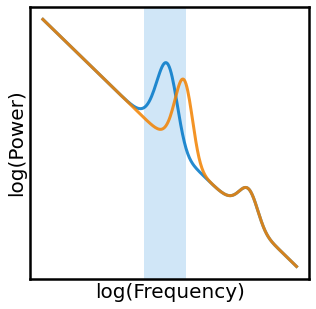

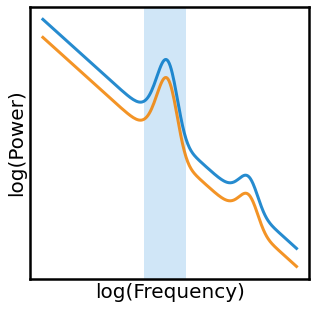

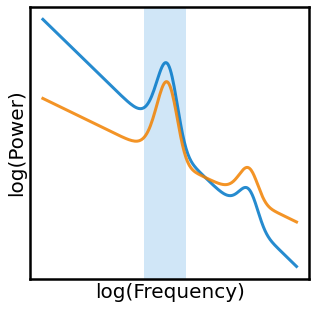

In [30]:
for ind, powers in enumerate(list(all_powers.values())):
    _, ax = plt.subplots(figsize=(5, 5))
    plot_spectra_shading(freqs, [powers_base, powers], 
                         [8, 12], shade_colors=BAND_COLORS['alpha'],
                         lw=3, alpha=0.85,
                         log_freqs=True, log_powers=True, ax=ax)
    
    colors = ['#0077c7', '#f28100']
    for line, color in zip(ax.get_lines(), colors):
        line.set_color(color)
    plt.xticks([]); plt.yticks([]);
    
    #save_fig(SAVE, 'psd_conflations_{}.pdf'.format(str(ind)))